**Variable Screening and Transformation**

Goals:
- remove redundant covariates
- stabilize distributions
- produce a candidate set identical for all models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
df = pd.read_csv("/Users/inesschwartz/Desktop/training_data.csv")
df.head()

,site_info_id,X_coord,Y_coord,profile,district,MRVBF,RLD,aspect,aspect_cos,aspect_sin,...,precip_warmest_quarter,precip_wettest_month,precip_wettest_quarter,temp_annual_range,temp_seasonality,landsurface_value,formation,faosoil_id,litho_value,log_soc_stock
0,2770,12.161278,-15.222598,1_57,Namibe,3.154941,56.441210,193.73800,0.002505,-0.099684,...,47,24,50,15.400000,25.000542,1,204,131.0,1,0.123792
1,48,12.575774,-4.866985,1_59,Cabinda,1.309310,87.681090,167.89279,-0.005290,0.026958,...,525,196,525,13.382994,18.245573,5,1,112.0,5,1.344501
2,881,17.081955,-9.274587,1_63,Malanje,-0.007585,226.943010,152.63528,0.142316,0.283865,...,542,227,588,19.820923,4.635531,2,113,62.0,2,1.309453
3,2698,13.455059,-14.977228,10_55,Huila,1.245921,71.276505,188.58809,-0.412049,-0.074023,...,163,177,438,20.374357,17.226534,2,113,62.0,2,1.263857
4,2139,16.269295,-12.580465,100_56,Huambo,3.043891,95.820830,188.93633,0.271031,-0.047712,...,322,250,654,21.457123,15.427565,2,97,43.0,2,1.260593


In [3]:
print(df.X_coord.min(), df.X_coord.max())
print(df.Y_coord.min(), df.Y_coord.max())


12.035 23.962458
-17.998255 -4.446332


In [4]:
# (Optional) remove obviously redundant covariates
#    - constant columns
#    - perfectly correlated pairs

# Drop columns with a single unique value
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
df_reduced = df.drop(columns=constant_cols)

# Drop perfectly correlated columns (|r|=1.0)
corr_matrix = df_reduced.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
perfect_corr = [column for column in upper.columns if any(upper[column] == 1.0)]
# df_reduced = df_reduced.drop(columns=perfect_corr)

# Columns you want to retain even if flagged as perfectly correlated
keep_cols = [
    "aspect_sin",
    "TWI",
    "annual_mean_temp",
    "temp_annual_range",
    "temp_seasonality"
]

# Drop perfectly correlated columns except the ones you want to keep
perfect_corr_to_drop = [col for col in perfect_corr if col not in keep_cols]
df_reduced = df_reduced.drop(columns=perfect_corr_to_drop)


print("Dropped constant cols:", constant_cols)
print("Dropped perfectly correlated cols:", perfect_corr_to_drop)


Dropped constant cols: []
Dropped perfectly correlated cols: ['roughness', 'max_temp_warmest_month', 'mean_temp_driest_quarter', 'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter', 'min_temp_coldest_month']


In [5]:
# ----------------------------
# 2. Numeric columns
# ----------------------------
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns

# ----------------------------
# 3. Output folder
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/training_eda_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------
# 4. Plot histograms in a grid
# ----------------------------
n_cols = 4  # columns in grid
n_rows = int(np.ceil(len(numeric_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color="steelblue")
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(out_dir / "histograms_grid.png", dpi=150)
plt.close()
print(f"Histograms saved to: {out_dir}")

Histograms saved to: /Users/inesschwartz/Desktop/training_eda_histograms


In [6]:
df_reduced.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district', 'MRVBF',
       'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
       'relief', 'ridge_levels', 'slope', 'TWI', 'valleydepth',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
       'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range',
       'temp_seasonality', 'landsurface_value', 'formation', 'faosoil_id',
       'litho_value', 'log_soc_stock'],
      dtype='object')

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

df_reduced

# ----------------------------
# 2. List topographic / DEM-derived columns
# ----------------------------
topo_cols = [
    "MRVBF",
    "RLD",
    "aspect",
    "aspect_cos",
    "aspect_sin",
    "slope",
    "TWI",
    "valleydepth",
    "ridge_levels",
    "DEM",
    "flow_accumulation"
]

# ----------------------------
# 3. Replace known NoData placeholders with NaN
# ----------------------------
nodata_values = [-99999, -9999, -999, 99999, 9999]  # extend if needed
for col in topo_cols:
    df_reduced[col] = df_reduced[col].replace(nodata_values, np.nan)

# ----------------------------
# 4. Clip outliers based on percentiles
# ----------------------------
def clip_outliers(series, lower_pct=1, upper_pct=99):
    lower = np.percentile(series.dropna(), lower_pct)
    upper = np.percentile(series.dropna(), upper_pct)
    return series.clip(lower, upper)

for col in topo_cols:
    df_reduced[col] = clip_outliers(df_reduced[col], lower_pct=1, upper_pct=99)

# ----------------------------
# 5. Optional: plot histograms after clipping
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/topo_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

for col in topo_cols:
    plt.figure(figsize=(5,4))
    sns.histplot(df[col].dropna(), bins=30, kde=True, color='steelblue')
    plt.title(f"Histogram of {col} (clipped)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
    plt.close()

print(f"Clipping done. Histograms saved in: {out_dir}")

# ----------------------------
# 6. Save cleaned dataset
# ----------------------------
clean_csv_path = "/Users/inesschwartz/Desktop/training_data_topo_cleaned.csv"
df_reduced.to_csv(clean_csv_path, index=False)
print(f"Cleaned CSV saved: {clean_csv_path}")


Clipping done. Histograms saved in: /Users/inesschwartz/Desktop/topo_histograms
Cleaned CSV saved: /Users/inesschwartz/Desktop/training_data_topo_cleaned.csv


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# 1. Load training data
# ----------------------------
csv_path = "/Users/inesschwartz/Desktop/training_data_topo_cleaned.csv"
df = pd.read_csv(csv_path)

# ----------------------------
# 2. List bioclimatic variables
# ----------------------------
bioclim_cols = [
    'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
    'isothermality', 'precip_coldest_quarter',
    'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
    'precip_warmest_quarter', 'precip_wettest_month',
    'precip_wettest_quarter', 'temp_annual_range',
    'temp_seasonality'
]

# ----------------------------
# 3. Replace extreme placeholder values with NaN
# ----------------------------
# thresholds based on plausible ranges for temperature (°C) and precipitation (mm)
for col in bioclim_cols:
    df[col] = df[col].apply(lambda x: np.nan if x < -1e5 or x > 1e5 else x)

# ----------------------------
# 4. Function for percentile-based clipping
# ----------------------------
def clip_percentiles(series, lower=1, upper=99):
    series_clean = series.dropna()
    lower_val, upper_val = np.percentile(series_clean, [lower, upper])
    return series.clip(lower_val, upper_val)

# ----------------------------
# 5. Plot and save histograms
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/bioclim_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

for col in bioclim_cols:
    clipped = clip_percentiles(df[col])
    plt.figure(figsize=(5,4))
    sns.histplot(clipped, bins=30, kde=True, color='darkgreen')
    plt.title(f"Histogram of {col} (clipped 1-99%)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
    plt.close()

print(f"Bioclimatic histograms saved in: {out_dir}")

# ----------------------------
# 6. Save cleaned dataset
# ----------------------------
clean_csv_path = "/Users/inesschwartz/Desktop/training_data_bioclim_cleaned.csv"
df.to_csv(clean_csv_path, index=False)
print(f"Cleaned bioclim dataset saved: {clean_csv_path}")


Bioclimatic histograms saved in: /Users/inesschwartz/Desktop/bioclim_histograms
Cleaned bioclim dataset saved: /Users/inesschwartz/Desktop/training_data_bioclim_cleaned.csv


In [9]:
df.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district', 'MRVBF',
       'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
       'relief', 'ridge_levels', 'slope', 'TWI', 'valleydepth',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
       'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range',
       'temp_seasonality', 'landsurface_value', 'formation', 'faosoil_id',
       'litho_value', 'log_soc_stock'],
      dtype='object')

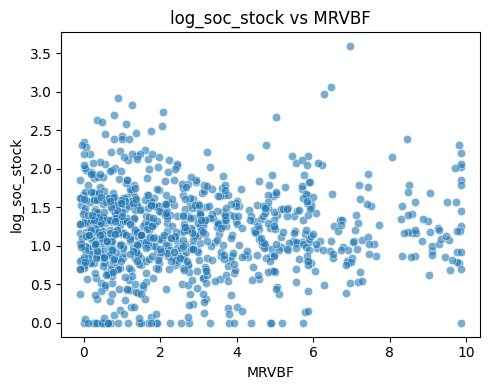

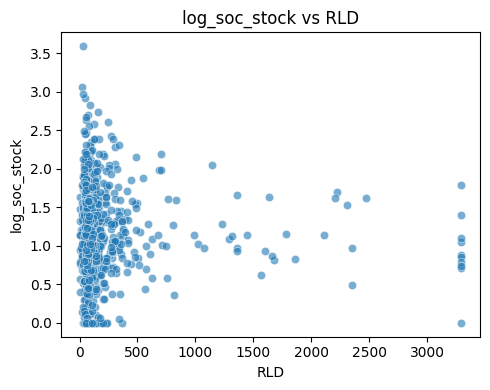

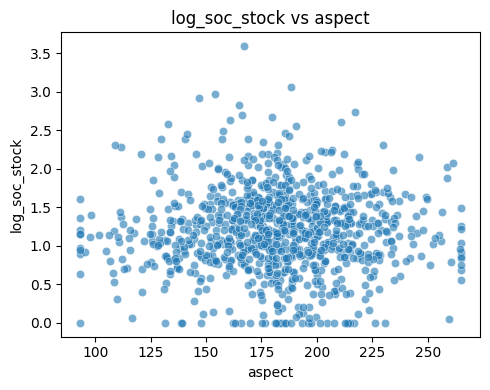

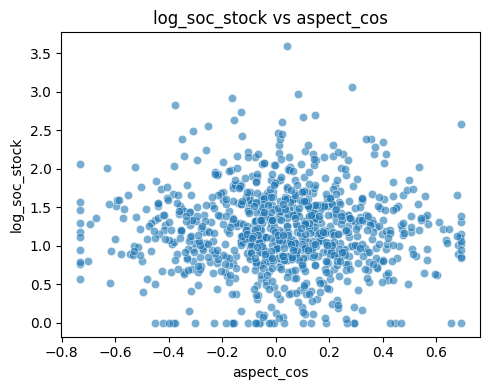

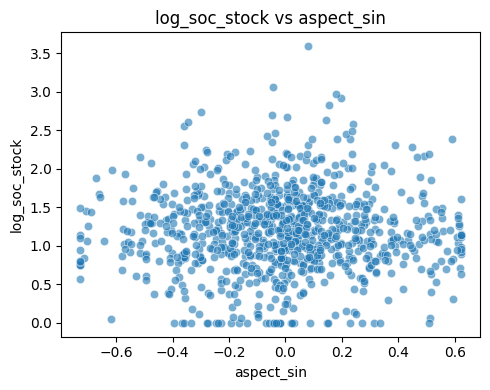

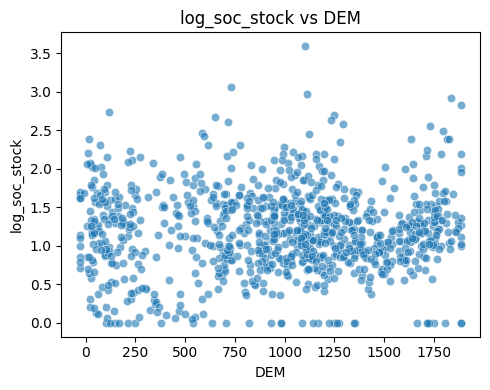

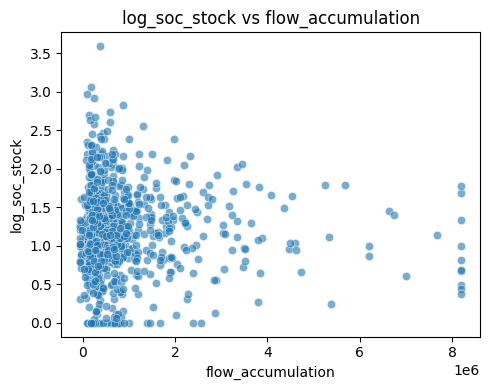

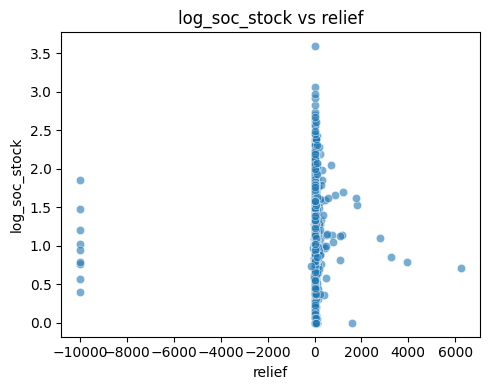

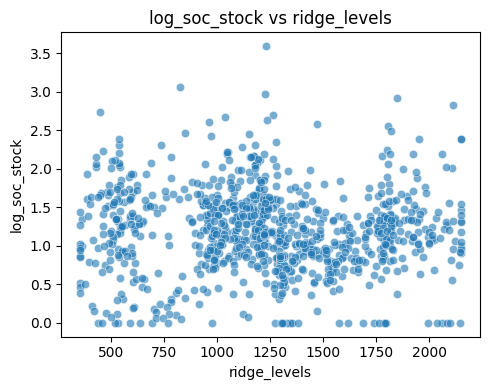

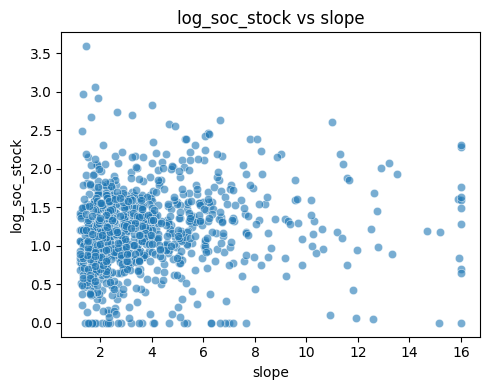

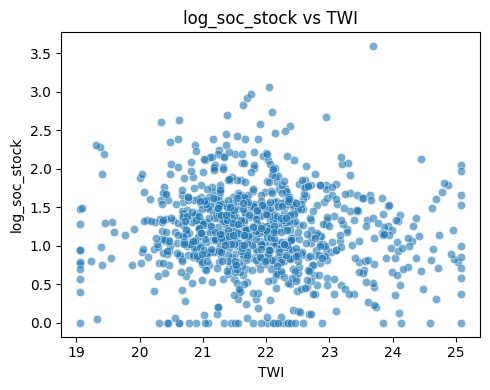

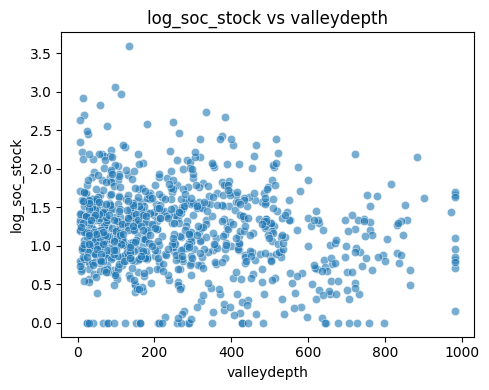

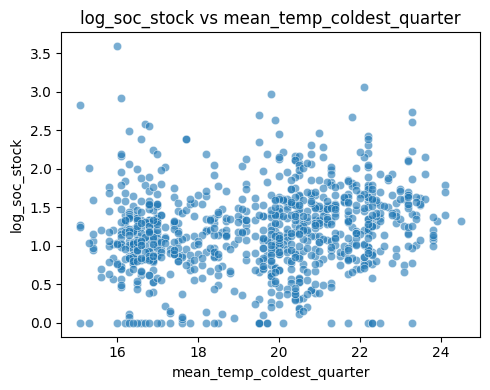

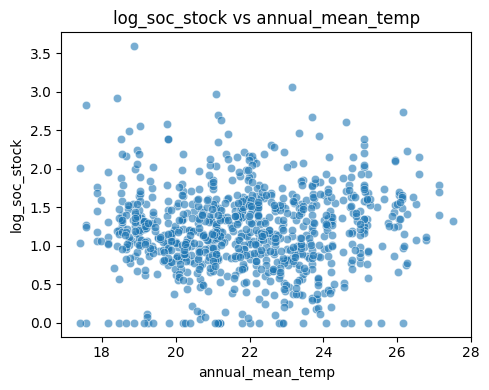

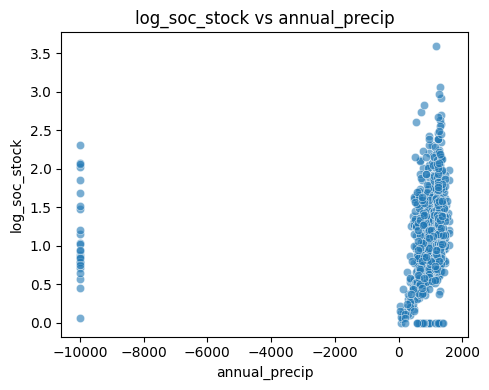

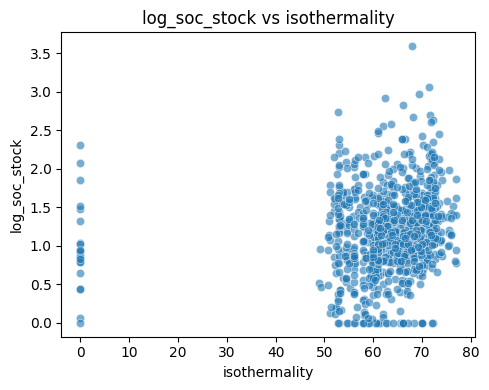

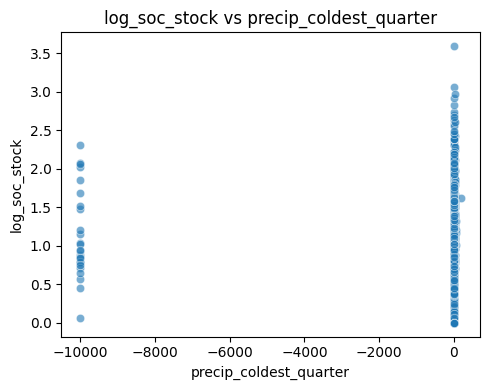

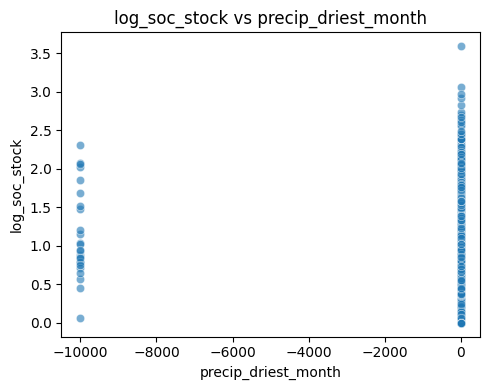

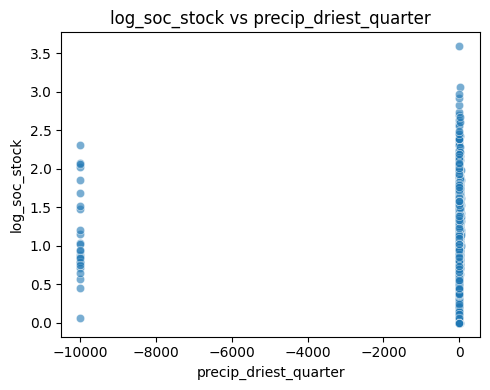

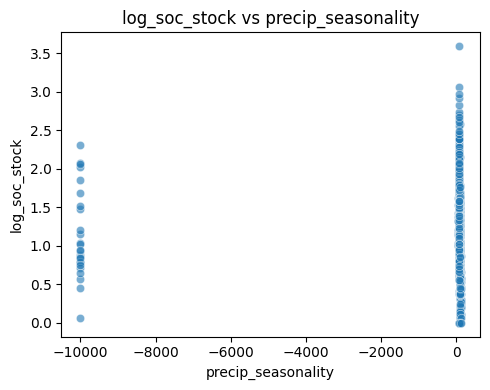

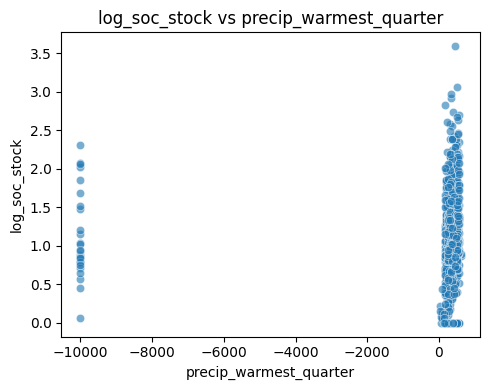

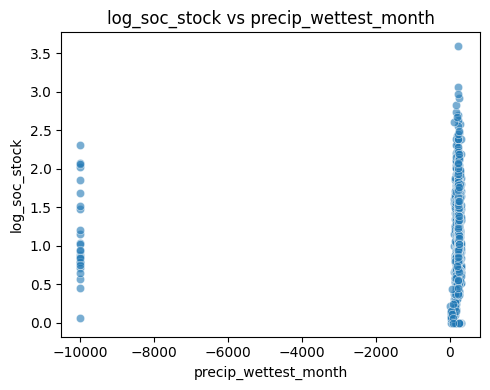

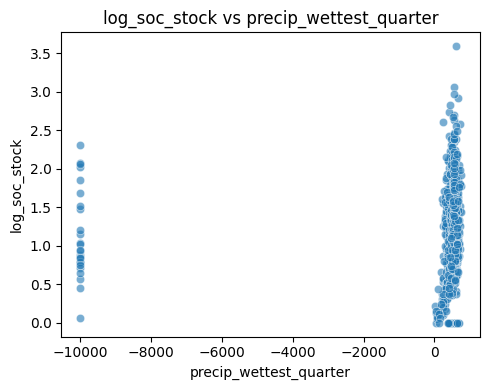

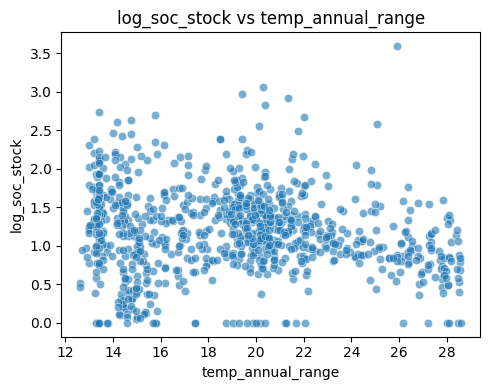

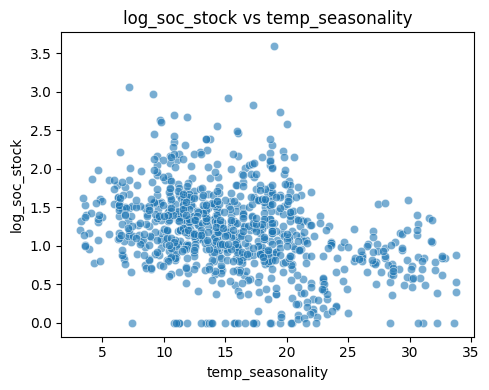

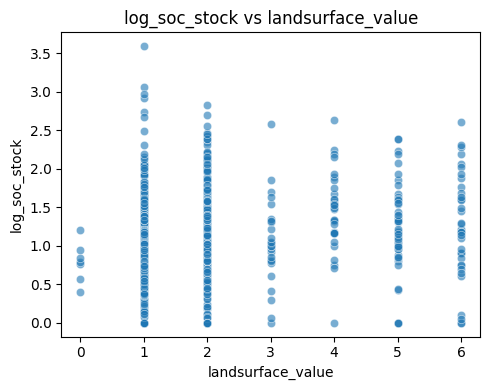

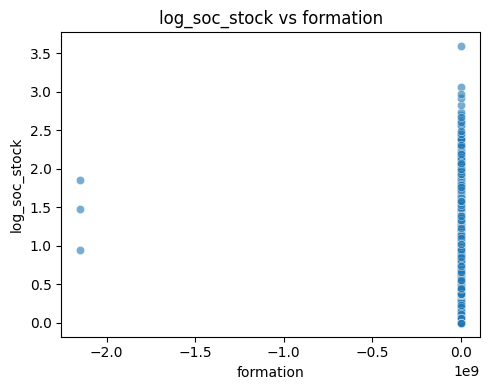

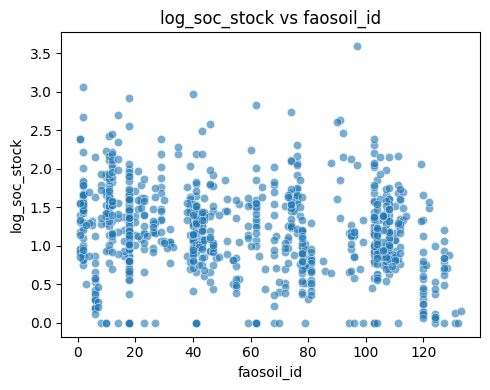

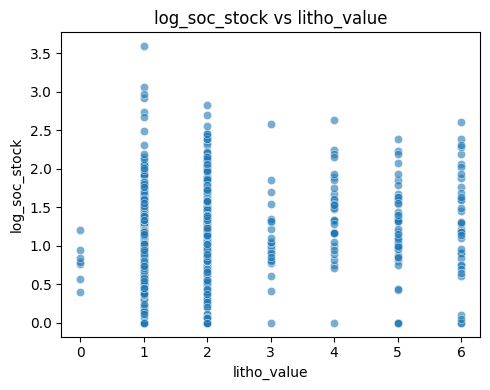

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric covariates
numeric_cols = [
    'MRVBF', 'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
    'relief', 'ridge_levels', 'slope', 'TWI', 'valleydepth',
    'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
    'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
    'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
    'precip_wettest_month', 'precip_wettest_quarter',
    'temp_annual_range', 'temp_seasonality', 'landsurface_value',
    'formation', 'faosoil_id', 'litho_value'
]

# Create scatter plots vs log_soc_stock
for col in numeric_cols:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=df, x=col, y='log_soc_stock', alpha=0.6)
    plt.title(f"log_soc_stock vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_soc_stock")
    plt.tight_layout()
    plt.show()


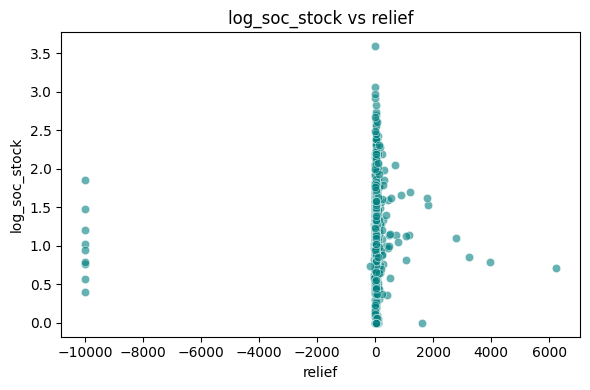

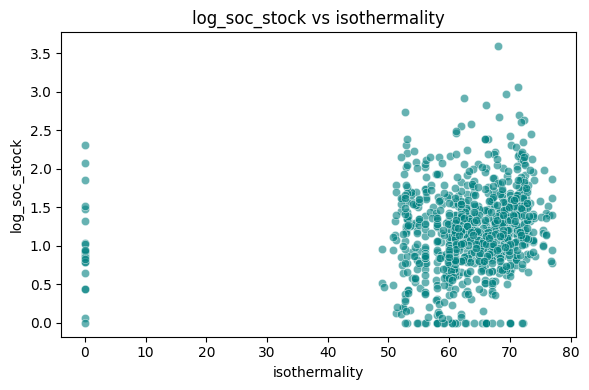

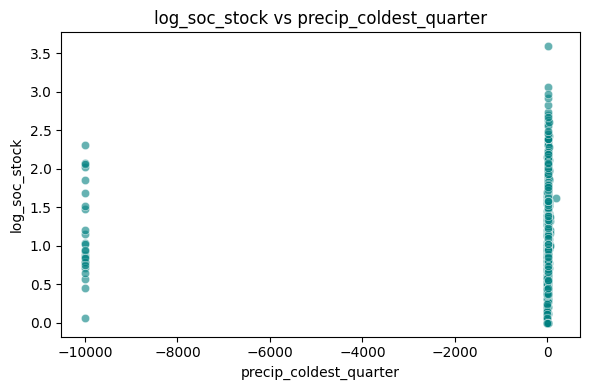


relief potential outliers (below 1st pct or above 99th pct):
     site_info_id      relief  log_soc_stock
56             56 -9999.00000       1.849645
73           3233  1080.45040       0.815282
115          2767 -9999.00000       0.571339
137            30 -9999.00000       1.481910
152           722  1830.77930       1.531594
156            58 -9999.00000       0.764571
159           297  1194.98750       1.696250
303           529  1779.16830       1.617655
458           255 -9999.00000       1.023427
644           409 -9999.00000       1.204147
676          3556 -9999.00000       0.403182
678           619  2788.83890       1.105922
695          3641 -9999.00000       0.790544
696          3644 -9999.00000       0.949267
701          3325  6250.73240       0.706684
745          3608  1616.95560       0.000000
781          1718  1163.06340       1.135434
784          3069  3243.39820       0.853072
785          3304  3949.86700       0.796138
921          1213  -169.76166       0.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables to inspect
vars_to_check = ['relief', 'isothermality', 'precip_coldest_quarter']

# Scatter plots with log_soc_stock
for col in vars_to_check:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y='log_soc_stock', alpha=0.6, color='teal')
    plt.title(f"log_soc_stock vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_soc_stock")
    plt.tight_layout()
    plt.show()

# ----------------------------
# Flag potential outliers (1st and 99th percentiles)
# ----------------------------
for col in vars_to_check:
    lower, upper = df[col].quantile([0.01, 0.99])
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"\n{col} potential outliers (below 1st pct or above 99th pct):")
    print(outliers[['site_info_id', col, 'log_soc_stock']])
    print(f"Number of potential outliers: {len(outliers)}")


In [12]:
# weird values:
# Replace placeholder NoData values with NaN.
df['relief'] = df['relief'].replace(-9999, np.nan)


In [13]:
df.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district', 'MRVBF',
       'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
       'relief', 'ridge_levels', 'slope', 'TWI', 'valleydepth',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'precip_coldest_quarter', 'precip_driest_month',
       'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter',
       'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range',
       'temp_seasonality', 'landsurface_value', 'formation', 'faosoil_id',
       'litho_value', 'log_soc_stock'],
      dtype='object')

## standardize to z score (necessary for regression kriging)

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# -------------------------------------------
# 1. Identify continuous variables to scale
# -------------------------------------------
continuous_cols = [
    'MRVBF', 'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM',
    'flow_accumulation', 'relief', 'ridge_levels', 'slope', 'TWI',
    'valleydepth', 'mean_temp_coldest_quarter', 'annual_mean_temp',
    'annual_precip', 'isothermality', 'precip_coldest_quarter',
    'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
    'precip_warmest_quarter', 'precip_wettest_month', 'precip_wettest_quarter',
    'temp_annual_range', 'temp_seasonality'
    # SOC target is excluded
]

# -------------------------------------------
# 2. Fit–transform with StandardScaler
# -------------------------------------------
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# -------------------------------------------
# 3. Keep categorical variables as-is
# -------------------------------------------
# Ensure they’re stored as categories (optional but recommended)
categorical_cols = ['litho_value', 'formation', 'landsurface_value']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# (Optional) confirm result
print(df[continuous_cols].describe().T[['mean', 'std']].head())
print(df[categorical_cols].dtypes)


                    mean       std
MRVBF       1.551403e-17  1.000546
RLD         6.935884e-17  1.000543
aspect     -5.572884e-16  1.000545
aspect_cos -7.706537e-18  1.000543
aspect_sin  0.000000e+00  1.000543
litho_value          category
formation            category
landsurface_value    category
dtype: object


## redundancy detection

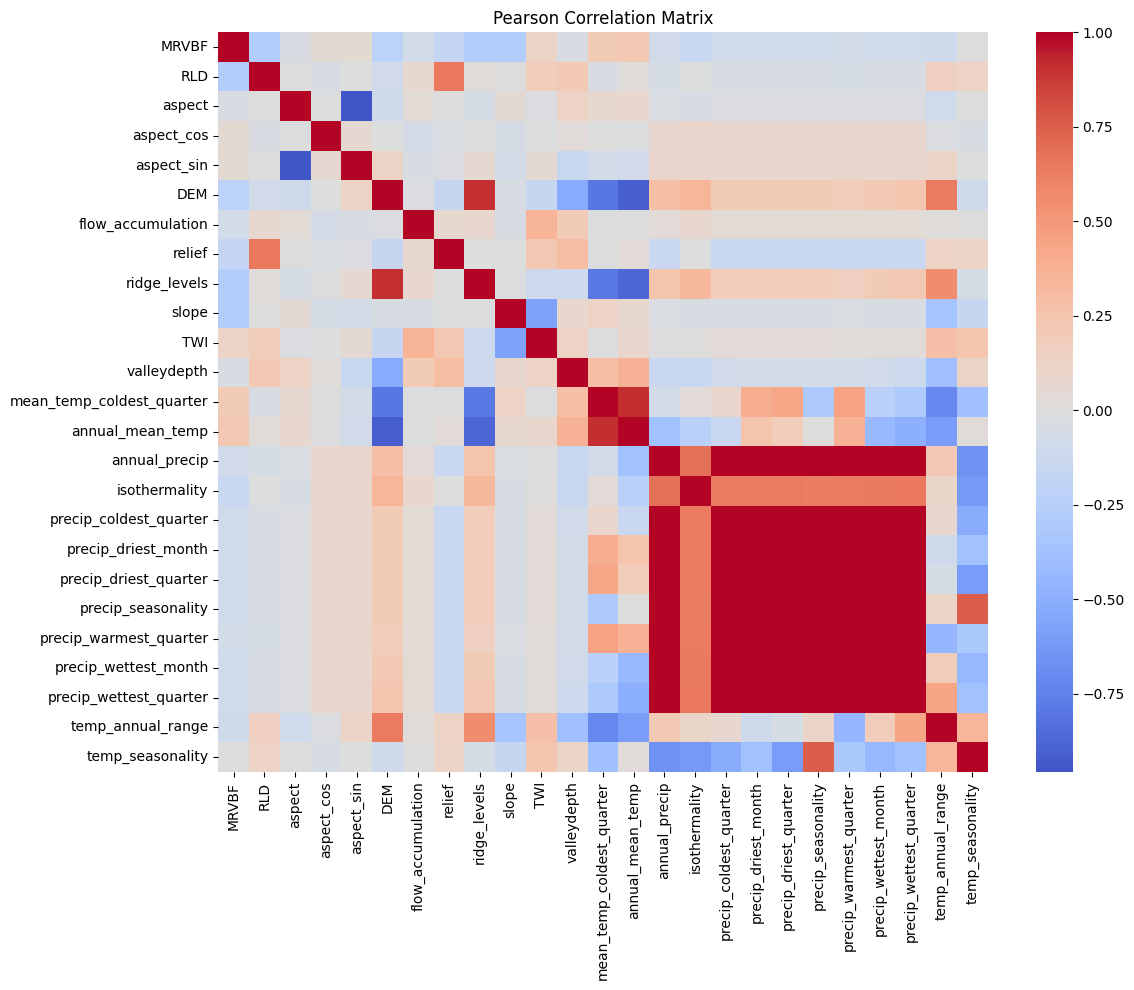

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------------------
# 1. Define continuous predictors
# -------------------------------------------
cont_cols = [
    'MRVBF','RLD','aspect','aspect_cos','aspect_sin','DEM',
    'flow_accumulation','relief','ridge_levels','slope','TWI','valleydepth',
    'mean_temp_coldest_quarter','annual_mean_temp','annual_precip','isothermality',
    'precip_coldest_quarter','precip_driest_month','precip_driest_quarter',
    'precip_seasonality','precip_warmest_quarter','precip_wettest_month',
    'precip_wettest_quarter','temp_annual_range','temp_seasonality'
]

# -------------------------------------------
# 2. Pearson correlation matrix
# -------------------------------------------
corr = df[cont_cols].corr(method="pearson")

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


In [16]:
# -------------------------------------------
# 3. Variance Inflation Factor (VIF)
# -------------------------------------------
X = df[cont_cols].dropna()  # VIF requires no missing values
vif_df = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nVariance Inflation Factors:")
print(vif_df)



Variance Inflation Factors:
                     variable           VIF
17        precip_driest_month  11017.343927
18      precip_driest_quarter   8213.883214
19         precip_seasonality   5230.564807
16     precip_coldest_quarter   1961.362453
12  mean_temp_coldest_quarter    762.321851
13           annual_mean_temp    623.652712
21       precip_wettest_month    439.599431
5                         DEM    295.404726
22     precip_wettest_quarter    253.631942
8                ridge_levels    218.490813
24           temp_seasonality    140.581224
14              annual_precip    119.376774
11                valleydepth     53.820050
20     precip_warmest_quarter     21.760592
4                  aspect_sin     12.940845
2                      aspect     12.794540
23          temp_annual_range      7.457623
7                      relief      2.723604
15              isothermality      2.631648
10                        TWI      2.416897
1                         RLD      2.093715
9  

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

#------------------------------------------------------
# 1. Define your working copy
#------------------------------------------------------
df_reduced = df.copy()

# --- Precipitation metrics: keep only annual_precip
drop_precip = [
    'precip_driest_quarter',
    'precip_wettest_quarter',
    'precip_coldest_quarter',
    'precip_warmest_quarter',
]

# --- Temperature metrics: keep annual_mean_temp + temp_annual_range
drop_temp = [
    'mean_temp_coldest_quarter',
]

# --- Topography: keep DEM as master, drop ridge_levels
drop_topo = ['ridge_levels']

# --- Aspect: keep cosine & sine encoding only
#drop_aspect = ['aspect']  # drop raw aspect

# Combine all to drop
drop_list = drop_precip + drop_temp + drop_topo

df_reduced = df_reduced.drop(columns=[c for c in drop_list if c in df_reduced.columns])

In [18]:
df_reduced.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district', 'MRVBF',
       'RLD', 'aspect', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
       'relief', 'slope', 'TWI', 'valleydepth', 'annual_mean_temp',
       'annual_precip', 'isothermality', 'precip_driest_month',
       'precip_seasonality', 'precip_wettest_month', 'temp_annual_range',
       'temp_seasonality', 'landsurface_value', 'formation', 'faosoil_id',
       'litho_value', 'log_soc_stock'],
      dtype='object')

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_6504/3175253987.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, loadings.PC1[i]*5, loadings.PC2[i]*5, color='red', alpha=0.7, head_width=0.2)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_6504/3175253987.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings.PC1[i]*5.2, loadings.PC2[i]*5.2, var, color='black', fontsize=9)


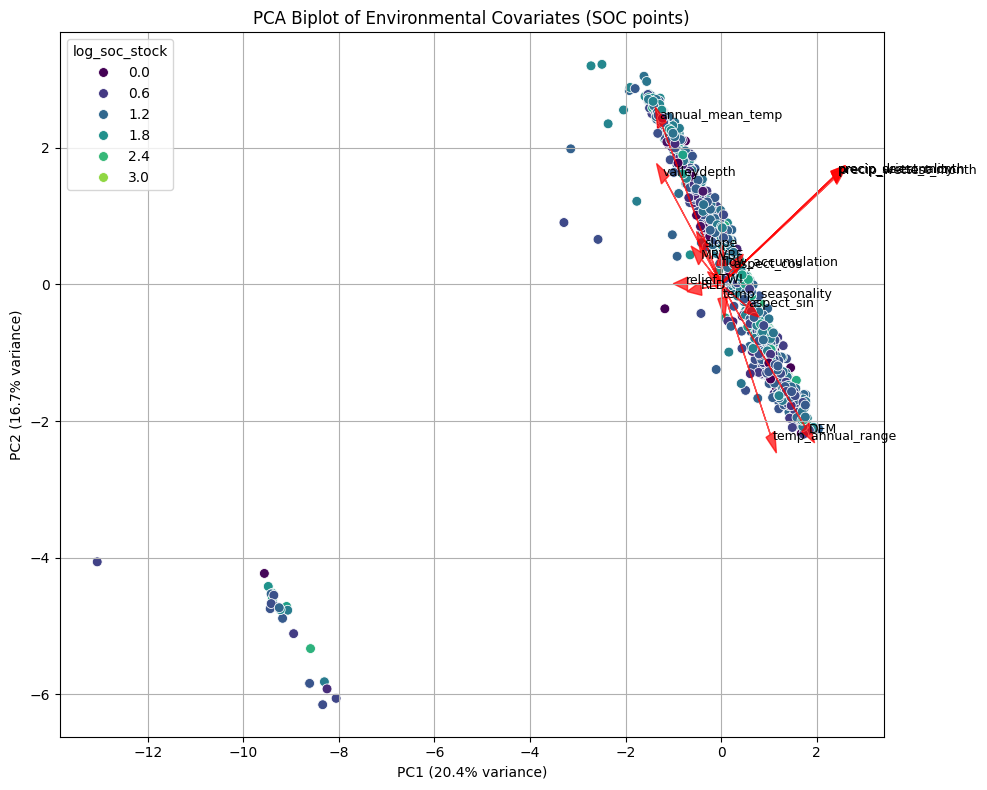

Variable loadings on first two PCs:
                            PC1       PC2
MRVBF                -0.081569  0.072490
RLD                  -0.083545 -0.012172
aspect_cos            0.049002  0.046996
aspect_sin            0.106775 -0.064290
DEM                   0.352062 -0.417891
flow_accumulation     0.001446  0.055570
relief               -0.140941  0.001467
slope                -0.070044  0.105106
TWI                  -0.007085  0.004604
valleydepth          -0.234218  0.306303
annual_mean_temp     -0.247949  0.466376
precip_driest_month   0.470066  0.314395
precip_wettest_month  0.472748  0.309690
precip_seasonality    0.469809  0.314578
temp_annual_range     0.205551 -0.439207
temp_seasonality      0.005702 -0.039004


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. Select numeric continuous covariates
# ------------------------------
continuous_covs = [
    'MRVBF', 'RLD', 'aspect_cos', 'aspect_sin', 'DEM', 'flow_accumulation',
    'relief', 'slope', 'TWI', 'valleydepth',
    'annual_mean_temp', 'precip_driest_month', 'precip_wettest_month', 'precip_seasonality',
    'temp_annual_range', 'temp_seasonality'
]

df_pca = df[continuous_covs].copy()
df_pca = df_pca.fillna(df_pca.median())  # handle missing values

# ------------------------------
# 2. Standardize the data
# ------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# ------------------------------
# 3. PCA
# ------------------------------
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
pc_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
pc_df['log_soc_stock'] = df['log_soc_stock'].values

# ------------------------------
# 4. Biplot
# ------------------------------
plt.figure(figsize=(10,8))

# Scatter points colored by SOC stock
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='log_soc_stock', palette='viridis', s=50)

# Add arrows for variable loadings
loadings = pd.DataFrame(pca.components_.T, index=continuous_covs, columns=['PC1', 'PC2'])
for i, var in enumerate(loadings.index):
    plt.arrow(0, 0, loadings.PC1[i]*5, loadings.PC2[i]*5, color='red', alpha=0.7, head_width=0.2)
    plt.text(loadings.PC1[i]*5.2, loadings.PC2[i]*5.2, var, color='black', fontsize=9)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA Biplot of Environmental Covariates (SOC points)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 5. Optional: print loadings
# ------------------------------
print("Variable loadings on first two PCs:\n", loadings)


In [20]:
df_reduced.head()
df_reduced.to_csv("/Users/inesschwartz/Desktop/model_training_data.csv")

In [21]:
# Count number of log_soc_stock == 0
num_zeros = (df_reduced['log_soc_stock'] == 0).sum()
print("Number of log_soc_stock values equal to 0:", num_zeros)

# Optionally, view these rows
zeros_df = df_reduced[df_reduced['log_soc_stock'] == 0]
print(zeros_df)


Number of log_soc_stock values equal to 0: 31
     site_info_id    X_coord    Y_coord  profile        district     MRVBF  \
6              17  12.733427  -4.627420   100_59         Cabinda  0.367166   
50           2346  14.407203 -13.179039   119_57        Benguela  0.599021   
59           2338  14.350289 -13.142974   121_57        Benguela  0.791120   
85           2014  16.281190 -12.263359   132_56          Huambo -0.379783   
89            500  15.280416  -7.815900   134_60    Uige e Zaire -0.932580   
125          2679  13.511016 -14.932662    15_55           Huila -1.039087   
149          3250  19.391127 -15.309560   156_66  Cuando-Cubango  0.920501   
197           175  12.632237  -6.163847  175C_60    Uige e Zaire -1.016978   
216           268  13.526319  -6.765987  181C_60    Uige e Zaire  0.167617   
262            98  12.356141  -5.314403   197_59         Cabinda -0.555610   
266           710  17.613716  -8.905341   198_65         Malanje  1.133898   
269          2290 

In [22]:
df_reduced.count

<bound method DataFrame.count of      site_info_id    X_coord    Y_coord profile      district     MRVBF  \
0            2770  12.161278 -15.222598    1_57        Namibe  0.113553   
1              48  12.575774  -4.866985    1_59       Cabinda -0.614734   
2             881  17.081955  -9.274587    1_63       Malanje -1.134382   
3            2698  13.455059 -14.977228   10_55         Huila -0.639748   
4            2139  16.269295 -12.580465  100_56        Huambo  0.069732   
..            ...        ...        ...     ...           ...       ...   
917          2136  16.246311 -12.566388   99_56        Huambo  0.075617   
918          1903  14.031297 -11.979545   99_58      Benguela -0.918235   
919          1689  18.164654 -11.382465   99_63       Malanje  0.282877   
920           348  15.692612  -7.160509   9C_60  Uige e Zaire -0.736594   
921          1213  16.357859  -9.986349   9C_63       Malanje -0.933417   

          RLD    aspect  aspect_cos  aspect_sin  ...  precip_dries

## z score standardization of continuous varaiables

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1. Drop zero log_soc_stock
# ----------------------------
df_clean = df_reduced[df_reduced['log_soc_stock'] > 0].copy()
print(f"Rows after dropping zeros: {df_clean.shape[0]}")

# ----------------------------
# 2. Identify categorical and continuous variables
# ----------------------------
categorical_cols = ['site_info_id', 'profile', 'district', 'X_coord', 'Y_coord',
                    'landsurface_value', 'formation', 
                    'litho_value', 'faosoil_id']

continuous_cols = [c for c in df_clean.columns 
                   if c not in categorical_cols + ['log_soc_stock']]

# ----------------------------
# 3. Standardize continuous covariates (Z-score)
# ----------------------------
scaler = StandardScaler()
df_clean[continuous_cols] = scaler.fit_transform(df_clean[continuous_cols])

# ----------------------------
# 4. Ready-to-train dataset
# ----------------------------
X = df_clean[continuous_cols + categorical_cols]  # predictors
y = df_clean['log_soc_stock']                       # target

print("Predictor matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# ----------------------------
# 5. Optional: save to CSV
# ----------------------------
output_path = "/Users/inesschwartz/Desktop/final_training_dataset.csv"
df_clean.to_csv(output_path, index=False)
print("Ready-to-train dataset saved at:", output_path)


Rows after dropping zeros: 891
Predictor matrix shape: (891, 28)
Target vector shape: (891,)
Ready-to-train dataset saved at: /Users/inesschwartz/Desktop/final_training_dataset.csv


In [24]:

print(df_clean.X_coord.min(), df_clean.X_coord.max())
print(df_clean.Y_coord.min(), df_clean.Y_coord.max())


12.035 23.962458
-17.998255 -4.446332
